<a href="https://colab.research.google.com/github/supertime1/Floyer_Analysis/blob/main/Cosinuss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Set up dependency

In [1]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss')

In [2]:
from data_container import config, DataFile
from data_container.api_db_sync import DBSync
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import pickle
import seaborn as sns
from utils import util
import pingouin as pg
import scipy.stats

2021-03-15 13:49:58 - DEBUG -       dc_config:  46 - DcConfig initialized


#2.Connect to Cosinuss Database

Connect to Cosinuss's database to get the API file handler. **Open redis-server.exe first before running configure_api()** .

In [3]:
# password: teeshau7aiMonoh9ee in case it is needed
api = util.configure_api('sonova_analysis', 'sonova.fremont.api', update_local=False)

2021-03-15 13:50:04 -  INFO -       dc_config: 226 - data_path is "C:\Users\57lzhang.US04WW4008\PycharmProjects\cosinuss\data"
2021-03-15 13:50:04 -  INFO -       dc_config: 141 - connect to database "sonova_analysis"
2021-03-15 13:50:04 -  INFO -       dc_config: 136 - init of data_container successful
2021-03-15 13:50:05 -  INFO -       api_login: 241 - login: sonova.fremont.api @ https://telecovid.earconnect.de
2021-03-15 13:50:06 -  INFO -       api_login: 253 - successful login, it expires 2021-03-16 01:50:05 expiring in 720.0 min


There are 164 files in local database


Generate a table from local local database by filtering the data with date

In [4]:
table = util.generate_table('2020-12-31', api)
print('There are', len(table), 'test records')
table.head()

There are 64 test records


,person,when,device,df id,duration,samples,cols,end
100,M9KH.BZYG (RaHe),2021-02-08 14:15:09,polar,1C2RATHBVH.C4CDEZ,1900-01-01 00:34:48,2.1 K,heart_rate,2021-02-08 14:49:57
101,M9KH.BZYG (RaHe),2021-02-08 14:15:14,cshell,1C2RATHBVH.38CD8K,1900-01-01 00:34:42,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:56
102,M9KH.BZYG (RaHe),2021-02-08 14:15:23,cshell,1C2RATHBVH.LEMWKL,1900-01-01 00:34:36,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:59
103,M9KH.BZYG (RaHe),2021-02-08 14:15:35,garmin,8QEK89R9B4.NZH5XL,1900-01-01 00:45:27,2.7 K,heart_rate,2021-02-08 15:01:02
104,M9KH.ME9A (LeLo),2021-02-08 15:23:00,polar,1C2RATHBVH.XCMFW1,1900-01-01 00:34:34,2.1 K,heart_rate,2021-02-08 15:57:34


Correct the label of 'cShell' and 'Biometric', in case they were mistakenly entered by Cosinuss

In [ ]:
# slow process, be careful to run it
correct_table = util.correct_label(table, api)

# save the table after running, so that you don't have to clean the label everytime
correct_table.to_pickle("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/local_db.pkl")

In [5]:
#load table from local directory if you've already done the label cleaning once
correct_table = pd.read_pickle("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/local_db.pkl")
correct_table.head()

,person,when,device,df id,duration,samples,cols,end
100,M9KH.BZYG (RaHe),2021-02-08 14:15:09,polar,1C2RATHBVH.C4CDEZ,1900-01-01 00:34:48,2.1 K,heart_rate,2021-02-08 14:49:57
101,M9KH.BZYG (RaHe),2021-02-08 14:15:14,cshell,1C2RATHBVH.38CD8K,1900-01-01 00:34:42,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:56
102,M9KH.BZYG (RaHe),2021-02-08 14:15:23,biometric,1C2RATHBVH.LEMWKL,1900-01-01 00:34:36,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:59
103,M9KH.BZYG (RaHe),2021-02-08 14:15:35,garmin,8QEK89R9B4.NZH5XL,1900-01-01 00:45:27,2.7 K,heart_rate,2021-02-08 15:01:02
104,M9KH.ME9A (LeLo),2021-02-08 15:23:00,polar,1C2RATHBVH.XCMFW1,1900-01-01 00:34:34,2.1 K,heart_rate,2021-02-08 15:57:34


Generate a statistic table for data analysis



In [ ]:
# find the row indices of paired floyer-polar device 
paired_idx_lst = util.find_pairs_row_index(correct_table, floyer_device='cshell')
# generate a paired sample class by using the paired row indices; 
# you also need to give the heart rate algorithm version
paired_sample_lst = util.generate_paired_samples(paired_idx_lst, 
                                                 correct_table, 
                                                 'v0',
                                                 api)
# save the paried sample list to save time on next run
with open("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/paired_sample_cshell.pkl", "wb") as fp:
    pickle.dump(paired_sample_lst, fp)

In [ ]:
# load the paired_sample_lst if you've done it previously
with open("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/paired_sample_cshell.pkl", "rb") as fp:
    paired_sample_lst = pickle.load(fp)
    
paired_sample_lst

In [ ]:
# generate a stats_table for stats analysis
stats_table = util.generate_stats_table(paired_sample_lst)
stats_table.head()

#3. Data Analysis

In [4]:
with open("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/stats.pkl", "rb") as fp:
    stats_table = pickle.load(fp)

In [6]:
st = util.Stats_Table(stats_table, 'cShell', 'v0')

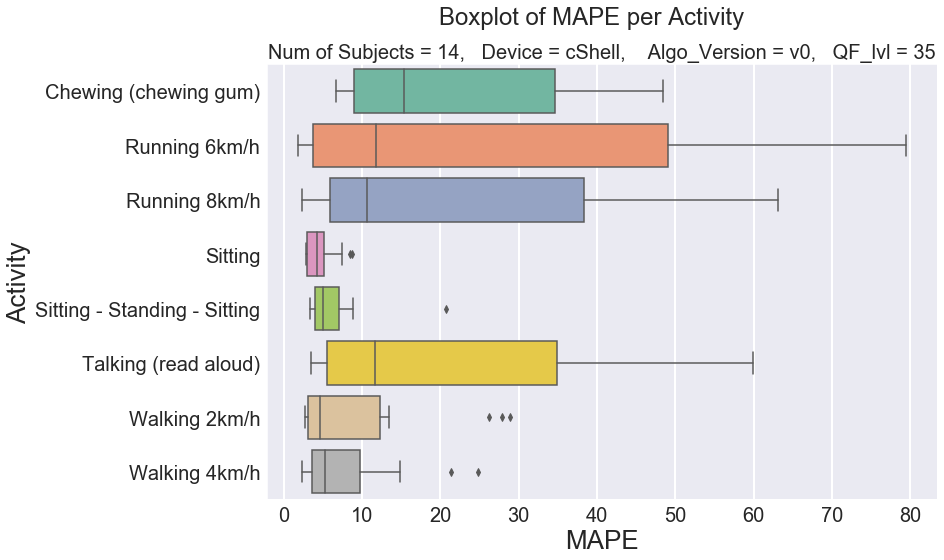

In [8]:
st.mape_boxplot(35, person_level=False)

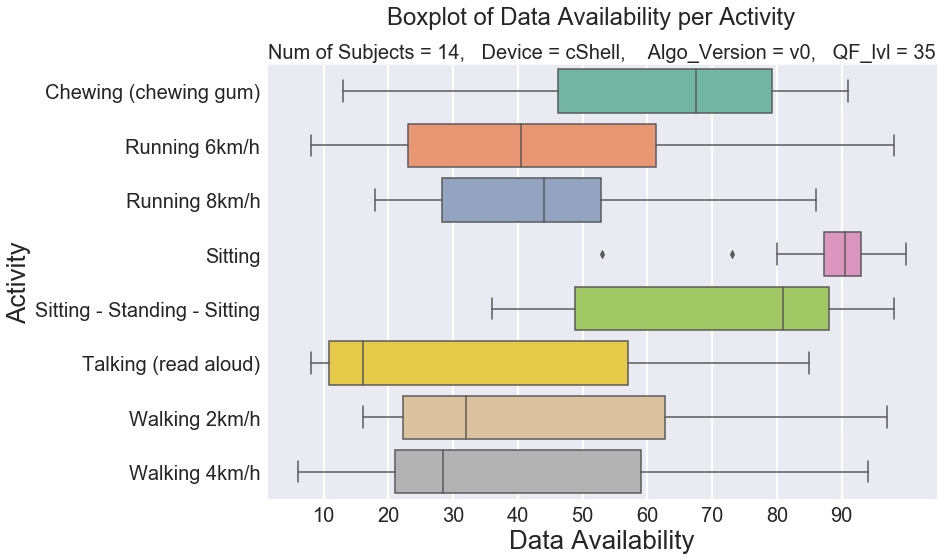

In [9]:
st.da_boxplot(35, person_level=False)

In [12]:
st.create_overview_table(35)

,Activity,Floyer hr_mean,Floyer hr_std,Polar hr_mean,Polar hr_std,Pearson Correlation,Mean Difference (Bias),Bias 95% LOA,MAPE,DA (%),ICC
0,Chewing (chewing gum),75,18,75,15,0.12,0,"[43.0, -43.0]",24.65,64.0,0.19
1,Running 6km/h,83,43,113,18,0.03,-30,"[61.0, -121.0]",14.41,46.0,0.14
2,Running 8km/h,112,47,139,20,0.31,-26,"[62.0, -115.0]",15.21,46.0,0.28
3,Sitting,68,16,72,16,0.84,-3,"[15.0, -21.0]",4.58,87.0,0.95
4,Sitting - Standing - Sitting,73,20,82,18,0.28,-9,"[36.0, -54.0]",6.07,72.0,0.52
5,Talking (read aloud),63,18,77,14,0.27,-14,"[25.0, -53.0]",10.38,37.0,0.22
6,Walking 2km/h,72,17,82,15,0.30,-10,"[27.0, -47.0]",8.10,44.0,0.43
7,Walking 4km/h,84,20,92,15,0.66,-7,"[23.0, -37.0]",5.94,44.0,0.76


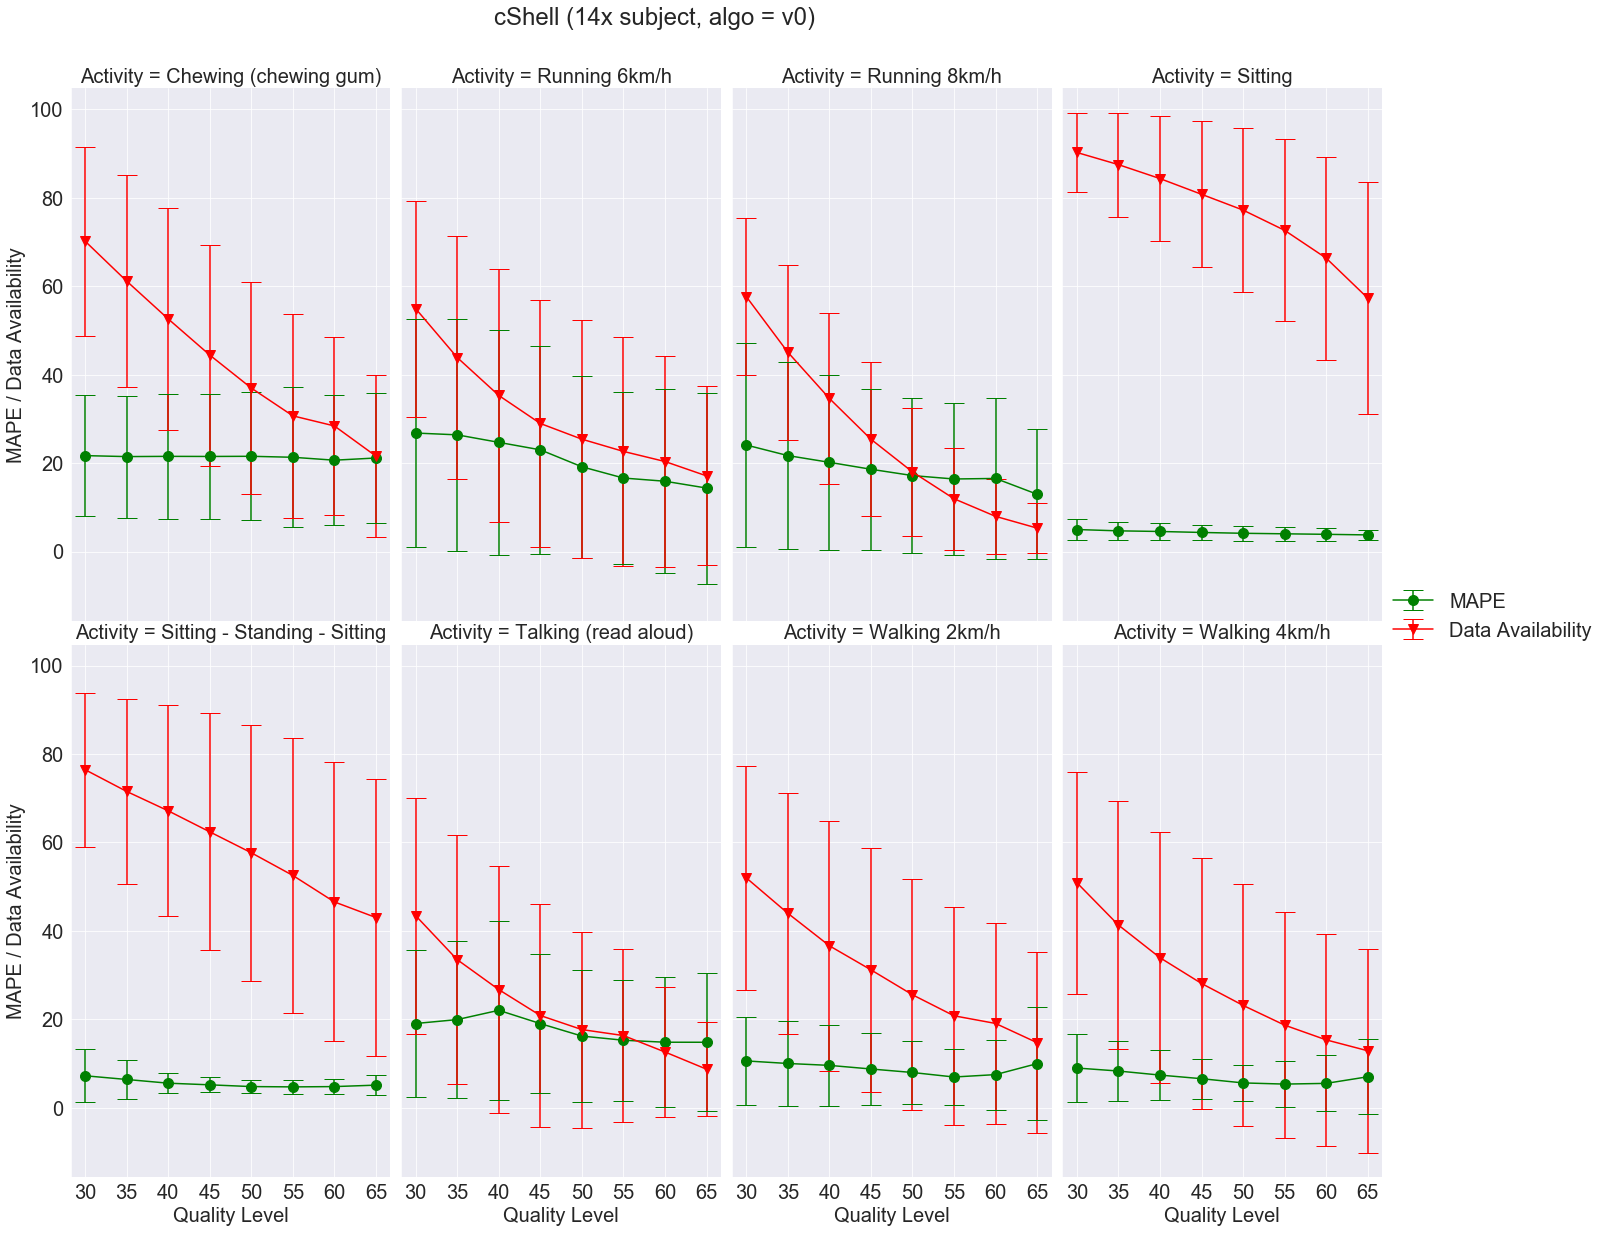

In [13]:
st.mape_vs_qa()

No handles with labels found to put in legend.


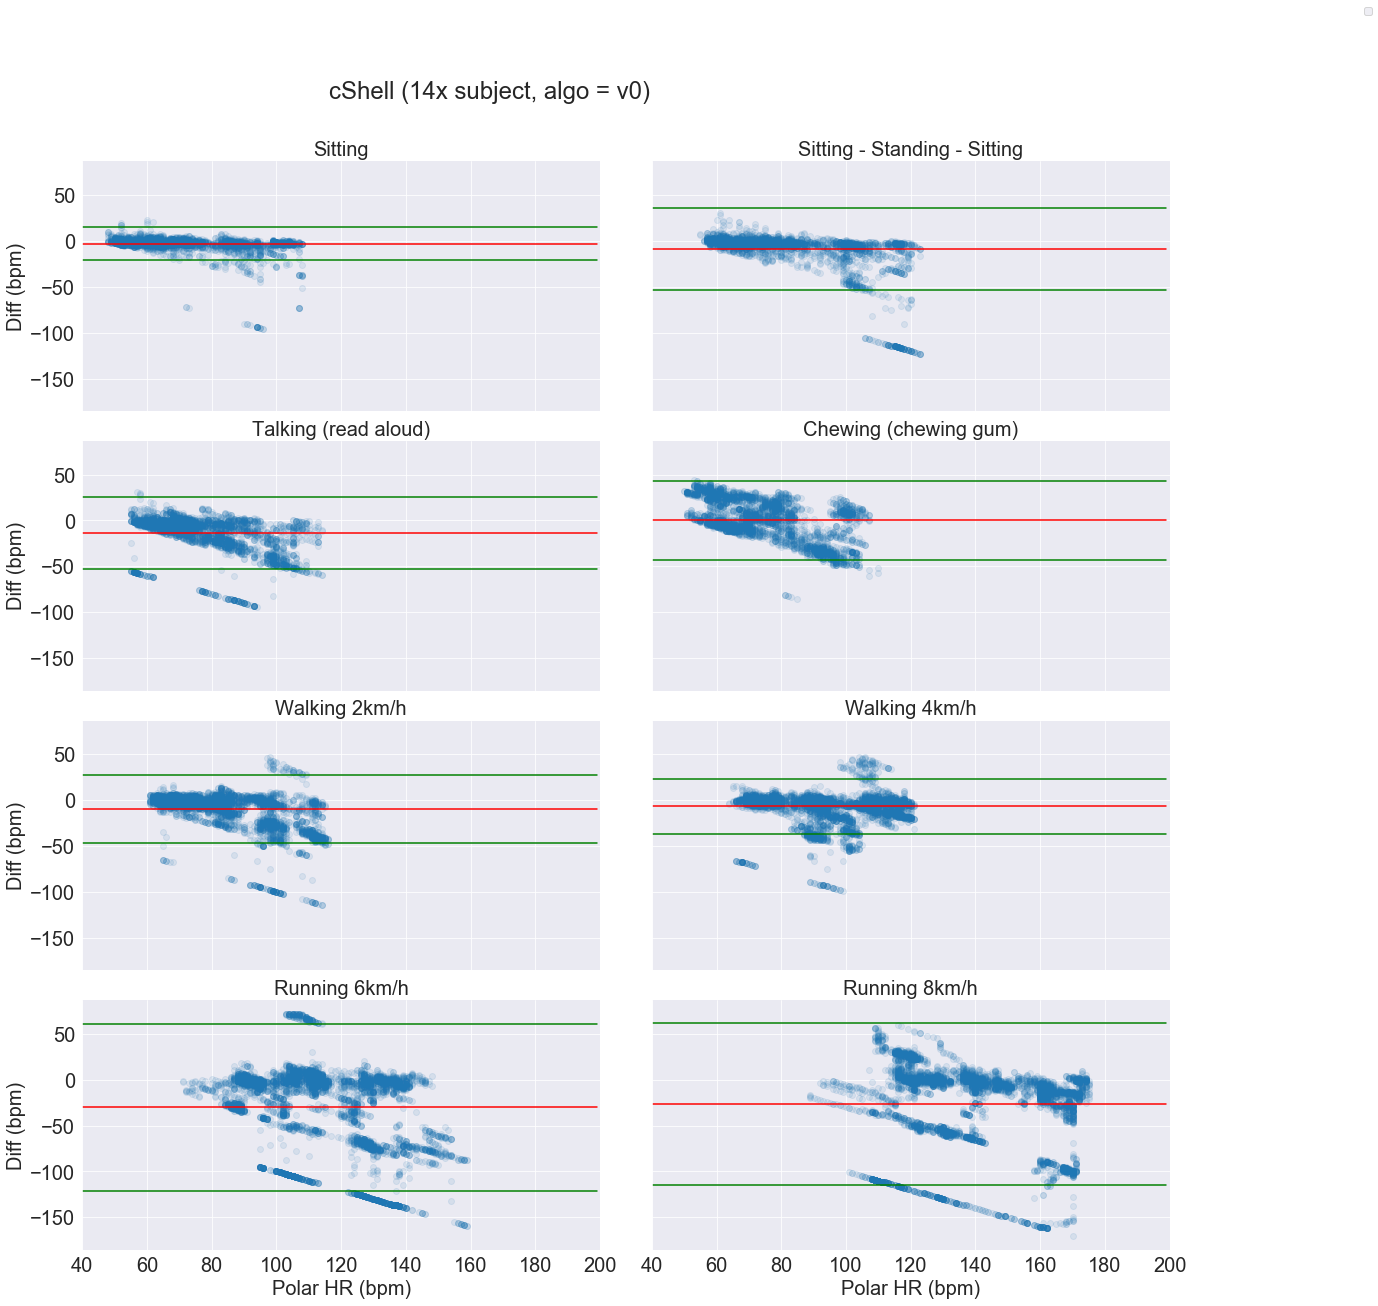

In [15]:
st.make_ba_plot()

In [74]:
def make_ba_plot(stats_table):
    '''
    make_ba_plot for each activity
    '''
    temp_table = stats_table.copy()
    temp_table['diff'] = temp_table['floyer_hr'] - temp_table['polar_hr']
    temp_table = temp_table[temp_table.activity != 'Unknown'].reset_index()

    def mean_diff_loa(data):
        mean = np.mean(data)
        std = np.std(data)
        loa_high = mean + 1.96 * std
        loa_low = mean - 1.96 * std
        return [loa_high, loa_low]

    g = sns.FacetGrid(temp_table,
                        col='activity',
                        col_wrap=2,
                        height=4,
                        aspect=2
                        )

    g = g.map(plt.scatter, 'polar_hr', 'diff', alpha=0.1)

    axes = g.axes.flatten()

    for i in range(len(axes)):
        activity_temp_table = temp_table[temp_table.activity == g.col_names[i]].reset_index()
        loa_high, loa_low = np.round(
            mean_diff_loa(activity_temp_table['floyer_hr'] - activity_temp_table['polar_hr']),1)
        mean_bias = round(np.mean(activity_temp_table['floyer_hr'] - activity_temp_table['polar_hr']), 1)
        x = np.arange(40, 200)
        y_mean_bias = [mean_bias] * len(x)
        y_loa_high = [loa_high] * len(x)
        y_loa_low = [loa_low] * len(x)
        axes[i].set_title(g.col_names[i], fontsize=20)
        axes[i].plot(x, y_mean_bias, 'r')
        axes[i].plot(x, y_loa_high, 'g')
        axes[i].plot(x, y_loa_low, 'g')
        axes[i].text(0.12, 0.1, f'Mean bias = {mean_bias},\nLOA High = {loa_high},\nLOA Low = {loa_low}', size='x-large',
                     horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        
        # axes[i].text(x[-1], y_mean_bias[-1], 'mean', size='x-large')
        # axes[i].text(x[-1], y_loa_high[-1], 'LOA-h', size='x-large')
        # axes[i].text(x[-1], y_loa_low[-1], 'LOA-l', size='x-large')

    g.set_xticklabels([40, 60, 80, 100, 120, 140, 160, 180, 200], fontsize=20)
    g.set_yticklabels(fontsize=20)
    g.set_xlabels('Polar HR (bpm)', fontsize=20)
    g.set_ylabels('Diff (bpm)', fontsize=20)
    g.set(xlim=(40, 200))
    g.fig.subplots_adjust(wspace=0.1, hspace=0.12)

    plt.legend(bbox_to_anchor=(1.4, 5))

In [ ]:
make_ba_plot(stats_table)